# Generation of MODIS Monthly Composites From Daily Dataset in DEA

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** `modis_oc_1d development` database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: 
```
module use /g/data/v10/public/modules/modulefiles;
module load dea
```    
* **Prerequisites:** The [introduction_to_MODIS_oceancolor](./introduction_to_modis_oceancolour.ipynb) notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats. Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instruments can provide some environmental information, however these are often very expensive and lack spatial and/or temporal coverage.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this example, we generate monthly composite from [IMOS](http://imos.org.au/) MODIS daily data. The worked example demonstrates how to:

1. Load in MODIS SST for a specific month
2. Generate the monthly composite
3. Plot the monthly composite
4. Export the monthly composite to a TIFF raster data 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the [Load packages](#LoadPackages) cell.
    
After finishing the analysis, return to the [Analysis parameters](#AnalysisParameters) cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

<a id='LoadPackages'></a>
## Load packages
Load key Python packages and supporting functions for the analysis.

In [32]:
%matplotlib inline
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
import matplotlib.pyplot as plt
import datacube
from datetime import datetime
import geopandas as gpd
import sys
import os
sys.path.append(os.path.expanduser('../../../dea-notebooks/Scripts/'))
import dea_datahandling

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that `modis_oc_1d` is development product. It is on a different database server `agdcstaging-db.nci.org.au`, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [2]:
config = {'db_hostname': 'agdcstaging-db.nci.org.au',
          'db_port': 6432,
          'db_database': 'dea_modis'}

dc = Datacube(config=config)

<a id='AnalysisParameters'></a>
### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `lat`: The latitude dimension (e.g., `(0, -40)`).
* `lon`: The longitude dimension (e.g., `(100, 160)`).
* `time`: The time dimension (e.g., `('2016-01-01', '2016-01-15')`).
* `resolution`: The desirable spatial resolution of the MODIS CHL data in decimal degrees (e.g., `(-0.1, 0.1)`). If the resolution is not the inherited resolution of the products,the retrived data will be resampled.
* `measurements`: The MODIS variables to load (e.g., `('sst', 'chl_gsm')`).
* `Australia_path` : path to location of a shapefile of Australia mainland used for plotting.

In [3]:
lat = (0,-60)
lon = (100,160)
time = ('2016-01-01','2016-01-31')
resolution = (-0.01, 0.01)
measurements = (['sst'])
Australia_path = '../../shapefiles/mainlands_100k.shp'

## Build query and load data

We will calculate the time taken to load the data as well.

In [4]:
# define query
query = {'lat': lat,
         'lon': lon,
        'time': time,
        'resolution': resolution,
        'measurements': measurements}

In [5]:
time1 = datetime.now()
MODIS_data = dc.load(product='modis_oc_1d', **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:01:04.073070 to finish


#### Mask the nodata (-999) as 'nan'

In [6]:
MODIS_data_clean = mask_invalid_data(MODIS_data)

In [7]:
MODIS_data_clean

<xarray.Dataset>
Dimensions:    (latitude: 6000, longitude: 6000, time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T11:59:59.999999 ... 2016-01-31T11:59:59.999999
  * latitude   (latitude) float64 -0.005 -0.015 -0.025 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 100.0 100.0 100.0 100.0 ... 160.0 160.0 160.0
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

## Create monthly composite
group by month and cacluate monthly average

In [8]:
MODIS_data_clean_monthly = MODIS_data_clean.groupby('time.month').mean('time',keep_attrs=True,skipna=True)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [21]:
MODIS_data_clean_monthly

<xarray.Dataset>
Dimensions:    (latitude: 6000, longitude: 6000, month: 1)
Coordinates:
  * latitude   (latitude) float64 -0.005 -0.015 -0.025 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 100.0 100.0 100.0 100.0 ... 160.0 160.0 160.0
  * month      (month) int64 1
Data variables:
    sst        (month, latitude, longitude) float32 nan nan nan ... 1.75 1.7525
Attributes:
    crs:      EPSG:4326

## Plot the monthly composites

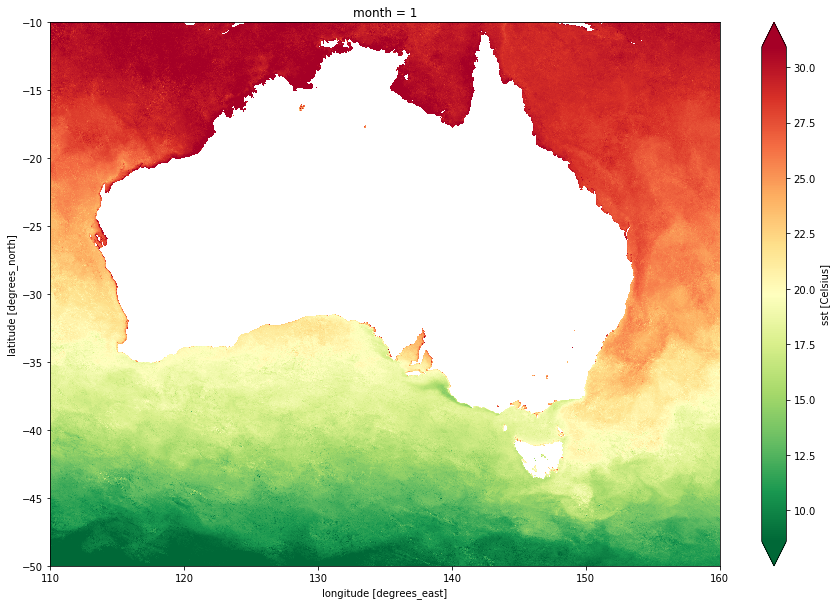

In [45]:
plt.figure(figsize=(15,10))
# shape_plot = gpd.read_file(Australia_path)
# shape_plot.plot(color='gray')
MODIS_data_clean_monthly.sst[:,1000:5000,1000:6000].plot(cmap='RdYlGn_r',robust=True)

#MODIS_data_clean_monthly.sst.plot(cmap='RdYlGn_r',robust=True)

### Select one location to prove the monthly mean is correctly calculated

In [48]:
MODIS_data_clean.isel(latitude=180,longitude=50).sst[0:31].mean()

<xarray.DataArray 'sst' ()>
array(29.426, dtype=float32)
Coordinates:
    latitude   float64 -1.805
    longitude  float64 100.5

In [49]:
MODIS_data_clean_monthly.isel(month=0,latitude=180,longitude=50).sst

<xarray.DataArray 'sst' ()>
array(29.426, dtype=float32)
Coordinates:
    latitude   float64 -1.805
    longitude  float64 100.5
    month      int64 1
Attributes:
    units:    Celsius
    crs:      EPSG:4326

## Export the montly composite to TIFF raster
use a datacube help function

In [65]:
geotransform=MODIS_data_clean_monthly.geobox.transform.to_gdal()

prj=MODIS_data_clean_monthly.geobox.crs.wkt

data = MODIS_data_clean_monthly.isel(month=0).sst.values
dea_datahandling.array_to_geotiff('../../temp/SST_201601.tif',data,geotransform,prj,nodata_val=-9999)